# Torch Adam - RMS Spot Size Optimization

- Note that optimization in PyTorch is fundamentally the same as the standard optimization using NumPy/SciPy. The only user-facing difference is the use of a torch-based optimizer.

In [1]:
import optiland.backend as be
from optiland import optic, optimization

be.set_backend("torch")  # Set the backend to PyTorch
be.grad_mode.enable()  # Enable gradient tracking

Define a starting lens:

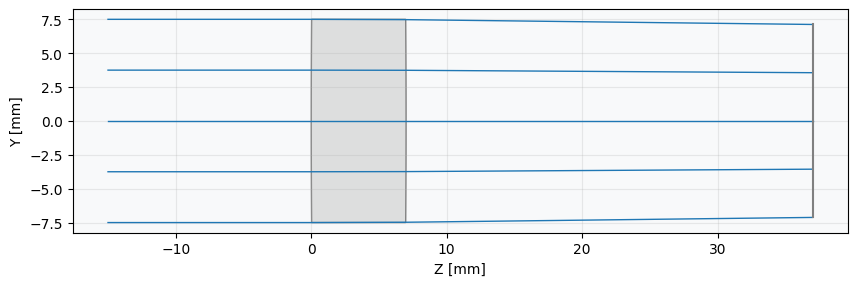

In [2]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, thickness=be.inf)
lens.add_surface(index=1, thickness=7, radius=1000, material="N-SF11", is_stop=True)
lens.add_surface(index=2, thickness=30, radius=-1000)
lens.add_surface(index=3)

# set aperture
lens.set_aperture(aperture_type="EPD", value=15)

# add field
lens.set_field_type(field_type="angle")
lens.add_field(y=0)

# add wavelength
lens.add_wavelength(value=0.55, is_primary=True)

# draw lens
_ = lens.draw(num_rays=5)

Define optimization problem:

In [3]:
problem = optimization.OptimizationProblem()

Add operands (targets for optimization):

In [4]:
"""
Define RMS spot size properties for the optimization:
    1. Surface number = -1, implying last surface (image surface)
    2. Normalized field coordinates (Hx, Hy) = (0, 0)
    3. Number of rays = 5, corresponds to number of rings in hexapolar distribution
        (see distribution documentation)
    4. Wavelength = 0.55 µm
    5. Pupil distribution = hexapolar
"""

input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "num_rays": 5,
    "wavelength": 0.55,
    "distribution": "hexapolar",
}

# add RMS spot size operand
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=1,
    input_data=input_data,
)

Define variables - let radius of curvature vary for both surfaces, at surface index 1 and 2:

In [5]:
problem.add_variable(lens, "radius", surface_number=1)
problem.add_variable(lens, "radius", surface_number=2)

Check initial merit function value and system properties:

In [6]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                30.0924 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   5.486 │   5.486 │            100 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤═════════╤══════════════╤══════════════╕
│    │ Variable Type   │   Surface │   Value │ Min. Bound   │ Max. Bound   │
╞════╪═══════════════

Define optimizer:

In [7]:
optimizer = optimization.TorchAdamOptimizer(problem)

Run optimization:

- Define learning rate (`lr`) and the learning rate decay factor (`gamma`)

In [8]:
res = optimizer.optimize(n_steps=250, lr=0.1, gamma=0.99, disp=True)

  Step 0001/250, Loss: 30.092424
  Step 0011/250, Loss: 29.753153
  Step 0021/250, Loss: 29.367258
  Step 0031/250, Loss: 28.914419
  Step 0041/250, Loss: 28.367346
  Step 0051/250, Loss: 27.686949
  Step 0061/250, Loss: 26.812805
  Step 0071/250, Loss: 25.643610
  Step 0081/250, Loss: 23.993845
  Step 0091/250, Loss: 21.483864
  Step 0101/250, Loss: 17.212940
  Step 0111/250, Loss: 8.675235
  Step 0121/250, Loss: 2.685997
  Step 0131/250, Loss: 0.765375
  Step 0141/250, Loss: 0.009119
  Step 0151/250, Loss: 0.021494
  Step 0161/250, Loss: 0.039819
  Step 0171/250, Loss: 0.014043
  Step 0181/250, Loss: 0.007309
  Step 0191/250, Loss: 0.008413
  Step 0201/250, Loss: 0.007488
  Step 0211/250, Loss: 0.007278
  Step 0221/250, Loss: 0.007291
  Step 0231/250, Loss: 0.007234
  Step 0241/250, Loss: 0.007232
  Step 0250/250, Loss: 0.007219


Print merit function value and system properties after optimization:

In [9]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │             0.00721827 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   0.085 │   0.085 │            100 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤══════════╤══════════════╤══════════════╕
│    │ Variable Type   │   Surface │    Value │ Min. Bound   │ Max. Bound   │
╞════╪═════════════

Draw final lens:

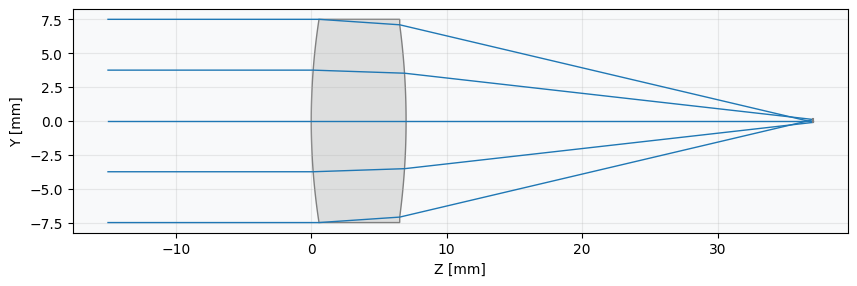

In [10]:
_ = lens.draw(num_rays=5)